In [1]:
import torchvision 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms   
import torch.optim as optim
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from PIL import Image
from numpy.linalg import norm
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 
from copy import copy

class AddGaussianNoise(object):
    def __init__(self, mean=0., std = .09):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

transform1 = transforms.Compose(
    [    
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261)),   
    ])

trainset = torchvision.datasets.CIFAR10(root='./', train=True,download=True, transform = transform1) 
validset = torchvision.datasets.CIFAR10(root='./', train=True,download=True, transform = transform) 
train = list(range(0, 45000,1))
valid = list(range(45000, 50000,1))
indices = torch.randperm(len(trainset))[:25000]
trainset1 = torch.utils.data.Subset(trainset, train)
validset1 = torch.utils.data.Subset(validset, valid)

trainloader_1 = torch.utils.data.DataLoader(trainset1, shuffle=True, num_workers=2,batch_size = 100)
validloader = torch.utils.data.DataLoader(validset1, shuffle=True, num_workers=2,batch_size = 100)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
testloader_1 = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2,batch_size = 100)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

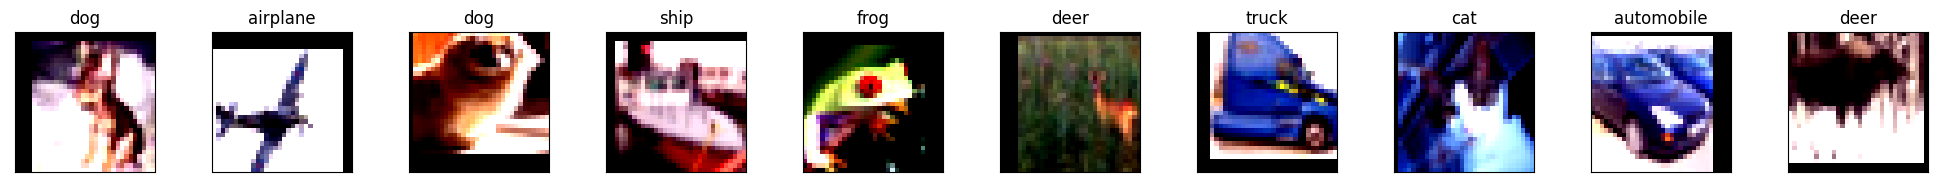

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
dataiter = iter(trainloader_1)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202



In [5]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [9]:
from torch.optim import lr_scheduler
"""
model = torchvision.models.vgg19(pretrained = True)
#for parameter in model.parameters():
      #  parameter.requires_grad = False
model.classifier[6] = nn.Sequential(
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(4096, 512, bias = True), 
                    nn.ReLU(), 
                    nn.Dropout(0.5, inplace=False),
                    nn.Linear(512, 10, bias = True))
#model.load_state_dict(torch.load("/notebooks/vgg25k1"))
#param = model.classifier[6] 
#print(param.type())
"""

"""                                          
#model.classifier[7] = nn.Linear(512, 10)

model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 10)

device_ids = [0, 1]
model = resnet110()

check_point = torch.load('/notebooks/resnet110-1d1ed7c2 (1).th', map_location='cuda:%d' % device_ids[0])

# cause the model are saved from Parallel, we need to wrap it
model = torch.nn.DataParallel(model)
model.load_state_dict(check_point['state_dict'])
"""

model = resnet20()
model = model.to(device)
print(get_n_params(model))
"""
for parameter in model.parameters():
    parameter.requires_grad = False
pp =0        
for name, param in model.named_parameters():
    if("layer1" in name ):
        print(name, param.size())
        nn1=1
        for s in list(param.size()):
            nn1 = nn1*s
        pp += nn1 
        param.requires_grad = True
    if("linear" in name ):
        print(name, param.size())
        nn1=1
        for s in list(param.size()):
            nn1 = nn1*s
        pp += nn1 
        param.requires_grad = True
    
print(pp)   
"""
#model.load_state_dict(torch.load("/notebooks/resnet205k1"))
criterion = nn.CrossEntropyLoss()
#for name, param in model.named_parameters():
#    print(name, param.size())

# Observe that all parameters are being optimized
#optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.0001, momentum = 0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.025, weight_decay=0.005)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.001)

269722


In [7]:
for parameter in model.parameters():
    parameter.requires_grad = False
pp =0        
for name, param in model.named_parameters():
    if("layer1" in name ):
        print(name, param.size())
        nn1=1
        for s in list(param.size()):
            nn1 = nn1*s
        pp += nn1 
        param.requires_grad = True
    if("linear" in name ):
        print(name, param.size())
        nn1=1
        for s in list(param.size()):
            nn1 = nn1*s
        pp += nn1 
        param.requires_grad = True
    
print(pp)  
for name, param in model.named_parameters():
    print(name, param.requires_grad)

layer1.0.conv1.weight torch.Size([16, 16, 3, 3])
layer1.0.bn1.weight torch.Size([16])
layer1.0.bn1.bias torch.Size([16])
layer1.0.conv2.weight torch.Size([16, 16, 3, 3])
layer1.0.bn2.weight torch.Size([16])
layer1.0.bn2.bias torch.Size([16])
layer1.1.conv1.weight torch.Size([16, 16, 3, 3])
layer1.1.bn1.weight torch.Size([16])
layer1.1.bn1.bias torch.Size([16])
layer1.1.conv2.weight torch.Size([16, 16, 3, 3])
layer1.1.bn2.weight torch.Size([16])
layer1.1.bn2.bias torch.Size([16])
layer1.2.conv1.weight torch.Size([16, 16, 3, 3])
layer1.2.bn1.weight torch.Size([16])
layer1.2.bn1.bias torch.Size([16])
layer1.2.conv2.weight torch.Size([16, 16, 3, 3])
layer1.2.bn2.weight torch.Size([16])
layer1.2.bn2.bias torch.Size([16])
linear.weight torch.Size([10, 64])
linear.bias torch.Size([10])
14666
conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
lay

In [13]:
 from numpy.linalg import norm
train_losslist = []
train_losslist1 = []
# number of epochs to train the model
n_epochs = [*range(300)] # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in n_epochs:
    # keep track of training and validation loss
    train_loss = 0.0
    train_loss1 = 0.0
    valid_loss = 0.0   
    ###################
    # train the model #
    ###################
    model.train()
    #model1.train()
    class_correct1 = list(0. for i in range(10))
    class_total1 = list(0. for i in range(10))
    for data, target in trainloader_1:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        #optimizer1.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        #output1 = model1(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #loss1 = criterion1(output1,target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #loss1.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        #exp_lr_scheduler.step()
        #optimizer1.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #train_loss1 += loss1.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(100):
            label = target.data[i]
            class_correct1[label] += correct[i].item()
            class_total1[label] += 1
    ######################    
    # validate the model #
    ######################
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        #if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(100):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            # calculate average losses
    valid_loss = valid_loss/len(validloader.dataset)
    train_loss = train_loss/len(trainloader_1.dataset)
    train_losslist.append(train_loss)
   # train_losslist1.append(train_loss1)
    """
    params1 = []
    norms1 = [] 
    for param in model.parameters(): 
      # print(param)
      temp = param.detach().cpu().numpy()
      norms1.append(norm(temp))
      params1.append(temp)
    params2 = []
    norms2 = []
    for param in model1.parameters(): 
   # print(param)
      temp = param.detach().cpu().numpy()
      norms2.append(norm(temp))
      params2.append(temp)    
    results = []
    for x in range(24):
      temp = params1[x]-params2[x]
      results.append(norm(temp))  
    """
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Training Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct1) / np.sum(class_total1),
    np.sum(class_correct1), np.sum(class_total1)))
    print('Validation Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Epoch: 0 	Training Loss: 0.238751 	Validation Loss: 0.401058
Training Accuracy (Overall): 91% (41300/45000)
Validation Accuracy (Overall): 87% (4368/5000)
Epoch: 1 	Training Loss: 0.242427 	Validation Loss: 0.713436
Training Accuracy (Overall): 91% (41179/45000)
Validation Accuracy (Overall): 82% (4102/5000)
Epoch: 2 	Training Loss: 0.236511 	Validation Loss: 0.538493
Training Accuracy (Overall): 91% (41271/45000)
Validation Accuracy (Overall): 83% (4196/5000)
Epoch: 3 	Training Loss: 0.238989 	Validation Loss: 0.405386
Training Accuracy (Overall): 91% (41336/45000)
Validation Accuracy (Overall): 87% (4369/5000)
Epoch: 4 	Training Loss: 0.237117 	Validation Loss: 0.404427
Training Accuracy (Overall): 91% (41279/45000)
Validation Accuracy (Overall): 88% (4411/5000)
Epoch: 5 	Training Loss: 0.235770 	Validation Loss: 0.426615
Training Accuracy (Overall): 91% (41250/45000)
Validation Accuracy (Overall): 87% (4357/5000)
Epoch: 6 	Training Loss: 0.238586 	Validation Loss: 0.453692
Training 

KeyboardInterrupt: 

In [19]:
test_loss = 0.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
matrix = np.zeros((10,10))
train_on_gpu = torch.cuda.is_available()
model.eval()
# iterate over test data
for data, target in testloader_1:
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(100):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        matrix[label][pred[i]] +=1

# average test loss
test_loss = test_loss/len(testloader_1.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
matrix = matrix/10
print(classes)
print(matrix)
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.687412

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[80.5  1.   3.4  1.9  0.   0.3  0.4  0.   2.8  9.7]
 [ 0.2 88.2  0.   0.3  0.   0.   0.   0.   0.2 11.1]
 [ 3.6  0.5 77.1  5.6  1.6  3.6  2.9  0.4  0.5  4.2]
 [ 1.3  1.3  1.1 80.5  0.5  8.6  2.2  0.   0.5  4. ]
 [ 1.4  0.3  3.5 10.7 67.   3.5  3.   1.9  1.2  7.5]
 [ 0.6  0.6  0.7 11.4  0.5 81.4  0.7  0.6  0.3  3.2]
 [ 0.6  0.7  1.1  5.   0.1  1.7 87.   0.   0.4  3.4]
 [ 2.   0.4  1.   4.6  0.7  4.6  0.1 75.8  0.5 10.3]
 [ 3.1  1.9  0.1  0.3  0.   0.3  0.3  0.  85.7  8.3]
 [ 0.1  1.5  0.2  0.1  0.   0.   0.   0.   0.3 97.8]]
Test Accuracy of airplane: 80% (805/1000)
Test Accuracy of automobile: 88% (882/1000)
Test Accuracy of  bird: 77% (771/1000)
Test Accuracy of   cat: 80% (805/1000)
Test Accuracy of  deer: 67% (670/1000)
Test Accuracy of   dog: 81% (814/1000)
Test Accuracy of  frog: 87% (870/1000)
Test Accuracy of horse: 75% (758/1000)
Test Accuracy of  ship: 85% (857/1000

In [11]:
torch.save(model.state_dict(), "resnet20testing")